In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn, Tensor
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchvision.transforms as transforms
from torch.utils.data import Subset
import matplotlib.pyplot as plt

In [34]:
from torchvision import datasets, transforms
import torch

batch_size = 64
target_class = 6 # Choisis la classe de CIFAR-10 (0 à 9)

# Transformation : conversion en tensor + normalisation
transform = transforms.Compose([
    transforms.ToTensor(),
])

# Téléchargement du dataset CIFAR-10
cifar10_train = datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)

# Filtrage pour ne garder qu'une seule classe
indices = [i for i, label in enumerate(cifar10_train.targets) if label == target_class]
cifar10_single_class = Subset(cifar10_train, indices)

# DataLoader
train_loader = torch.utils.data.DataLoader(cifar10_single_class, batch_size=batch_size, shuffle=True)

print(f"Nombre d'images dans la classe {target_class}: {len(cifar10_single_class)}")


Files already downloaded and verified
Nombre d'images dans la classe 6: 5000


In [35]:
len(indices)

5000

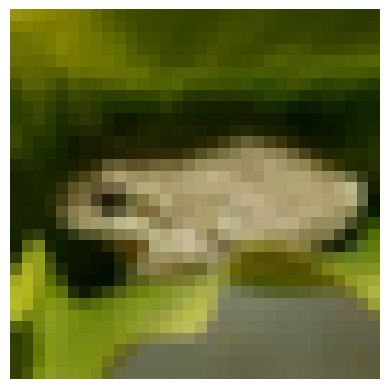

Label : 6
Shape de l'image : torch.Size([32, 32, 3])


In [67]:
img, label = cifar10_single_class[np.random.randint(0,5000)]  # récupère l'image et le label
img = img.permute(1, 2, 0)  # passe de (C,H,W) à (H,W,C)

plt.imshow(img)
plt.axis('off')
plt.show()

print("Label :", label)
print("Shape de l'image :", img.shape)

In [68]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cuda


In [69]:
import unet as UNET_OAI

model4 = UNET_OAI.UNetModel(
    image_size=32,                # CIFAR = 32x32
    in_channels=3,                # RGB
    model_channels=128,           # largeur du UNet
    out_channels=3,               # reconstruit 3 canaux
    num_res_blocks=2,             # 1 ou 2, 2 donne + de qualité
    attention_resolutions=[8],   # attention à 16x16
    channel_mult=[1, 1, 2, 2],    # standard CIFAR UNet
    dropout=0.1,                  # léger dropout
    use_checkpoint=True,         # mettre True si GPU faible
)

In [71]:
from nn import timestep_embedding

n_epochs = 1000
model4 = model4.to(device)

optim = torch.optim.Adam(model4.parameters(), lr=1e-4)

for epoch in range(n_epochs):

    # --- Charger un batch ---
    x_1, _ = next(iter(train_loader))
    x_1 = x_1.to(device).float()

    # --- Bruit de départ (x0) ---
    x_0 = torch.randn_like(x_1)

    B = x_1.size(0)

    # --- Temps Flow Matching ---
    t = torch.rand(B, device=device)

    # --- Interpolation ---
    x_t = (1 - t.view(B,1,1,1)) * x_0 + t.view(B,1,1,1) * x_1

    # --- Champ de vecteur "réel" ---
    v_true = x_1 - x_0

    # --- Embedding temporel (OBLIGATOIRE pour UNet OpenAI) ---
    v_pred = model4(x_t, t * 1000)


    # --- Loss Flow Matching ---
    loss = ((v_pred - v_true) ** 2).mean()

Skip to Main
len(indices)

5000

img, label = cifar10_single_class[np.random.randint(0,5000)]  # récupère l'image et le label
img = img.permute(1, 2, 0)  # passe de (C,H,W) à (H,W,C)

plt.imshow(img)
plt.axis('off')
plt.show()

print("Label :", label)
print("Shape de l'image :", img.shape)

Label : 6
Shape de l'image : torch.Size([32, 32, 3])

import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda

import unet as UNET_OAI

model4 = UNET_OAI.UNetModel(
    image_size=32,                # CIFAR = 32x32
    in_channels=3,                # RGB
    model_channels=128,           # largeur du UNet
    out_channels=3,               # reconstruit 3 canaux
    num_res_blocks=2,             # 1 ou 2, 2 donne + de qualité
    attention_resolutions=[8],   # attention à 16x16
    channel_mult=[1, 1, 2, 2],    # standard CIFAR UNet
    dropout=0.1,                  # léger dropout
    use_checkpoint=True,         # mettre True si GPU faible
)
from nn import timestep_embedding

n_epochs = 1000
model4 = model4.to(device)

optim = torch.optim.Adam(model4.parameters(), lr=1e-4)

for epoch in range(n_epochs):

    # --- Charger un batch ---
    x_1, _ = next(iter(train_loader))
    x_1 = x_1.to(device).float()

    # --- Bruit de départ (x0) ---
    x_0 = torch.randn_like(x_1)

    B = x_1.size(0)

    # --- Temps Flow Matching ---
    t = torch.rand(B, device=device)

    # --- Interpolation ---
    x_t = (1 - t.view(B,1,1,1)) * x_0 + t.view(B,1,1,1) * x_1

    # --- Champ de vecteur "réel" ---
    v_true = x_1 - x_0

    # --- Embedding temporel (OBLIGATOIRE pour UNet OpenAI) ---
    v_pred = model4(x_t, t * 1000)


    # --- Loss Flow Matching ---
    loss = ((v_pred - v_true) ** 2).mean()

    # --- Optimisation ---
    optim.zero_grad()
    loss.backward()
    optim.step()

    if(epoch%50 == 0):
        print(f"[epoch {epoch}] loss = {loss.item():.4f}")

[epoch 0] loss = 0.8485
[epoch 50] loss = 0.3133
[epoch 100] loss = 0.1814
[epoch 150] loss = 0.1142
[epoch 200] loss = 0.1126
[epoch 250] loss = 0.0901
[epoch 300] loss = 0.0863
[epoch 350] loss = 0.1216
[epoch 400] loss = 0.1292
[epoch 450] loss = 0.1381
[epoch 500] loss = 0.1248
[epoch 550] loss = 0.1088
[epoch 600] loss = 0.0986
[epoch 650] loss = 0.1079
[epoch 700] loss = 0.1115
[epoch 750] loss = 0.1113
[epoch 800] loss = 0.1048
[epoch 850] loss = 0.1033
[epoch 900] loss = 0.0962
[epoch 950] loss = 0.0996

Selection deleted
def generate_image(model, steps=100, device="cuda"):
    
    x_t = torch.randn(1, 3, 32, 32, device=device)
    dt = 1.0 / steps
    
    for step in range(steps):
        t_float = step * dt
        # convertir en entier pour l'embedding timestep
        if step == 0:
            print(t_float)
        t_int = torch.tensor([int(t_float * 1000)], device=device)
        v = model(x_t, t_int)
        x_t = x_t + dt * v  

    x_gen = torch.clamp(x_t, 0.0, 1.0)
    img = x_gen[0].permute(1, 2, 0).cpu().detach().numpy()
    
    return x_gen
Selection deleted
x_gen_OAI = generate_image(model4)

img = x_gen_OAI[0].permute(1, 2, 0).cpu().detach().numpy()
plt.imshow(img)
plt.axis("off")
plt.show()

0.0


    # --- Optimisation ---
    optim.zero_grad()
    loss.backward()
    optim.step()

    if(epoch%50 == 0):
        print(f"[epoch {epoch}] loss = {loss.item():.4f}")


[epoch 0] loss = 0.8485
[epoch 50] loss = 0.3133
[epoch 100] loss = 0.1814
[epoch 150] loss = 0.1142
[epoch 200] loss = 0.1126
[epoch 250] loss = 0.0901
[epoch 300] loss = 0.0863
[epoch 350] loss = 0.1216
[epoch 400] loss = 0.1292
[epoch 450] loss = 0.1381
[epoch 500] loss = 0.1248
[epoch 550] loss = 0.1088
[epoch 600] loss = 0.0986
[epoch 650] loss = 0.1079
[epoch 700] loss = 0.1115
[epoch 750] loss = 0.1113
[epoch 800] loss = 0.1048
[epoch 850] loss = 0.1033
[epoch 900] loss = 0.0962
[epoch 950] loss = 0.0996


In [84]:
def generate_image(model, steps=100, device="cuda"):
    
    x_t = torch.randn(1, 3, 32, 32, device=device)
    dt = 1.0 / steps
    
    for step in range(steps):
        t_float = step * dt
        # convertir en entier pour l'embedding timestep
        if step == 0:
            print(t_float)
        t_int = torch.tensor([int(t_float * 1000)], device=device)
        v = model(x_t, t_int)
        x_t = x_t + dt * v  

    x_gen = torch.clamp(x_t, 0.0, 1.0)
    img = x_gen[0].permute(1, 2, 0).cpu().detach().numpy()
    
    return x_gen

0.0


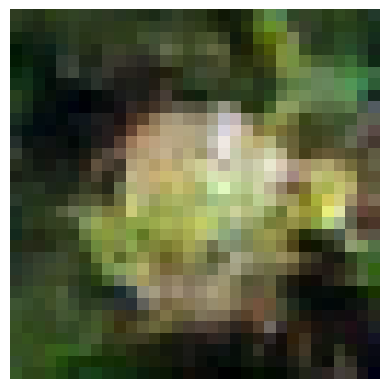

In [101]:
x_gen_OAI = generate_image(model4)

img = x_gen_OAI[0].permute(1, 2, 0).cpu().detach().numpy()
plt.imshow(img)
plt.axis("off")
plt.show()
